In [40]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc2/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [41]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 0, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 4
    nelecas = mf.nelec
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_h2(scf_checkfile)

# mc = run_casci(scf_checkfile, ci_checkfile)

converged SCF energy = -1.10630560865775  <S^2> = -1.3322676e-15  2S+1 = 1


In [42]:
#ABVMC
#
#
import importlib, recipes, bosonrecipes, bosonslater, bosonwf, bosonaccumulators, bosonwftools, bosonenergy
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonwf, bosonaccumulators, bosonwftools, bosonenergy] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

from recipes import DMC, VMC
tstep = 0.01
nconfig = 1000
nblocks = 100
nsteps_per_block = 4
dt_discard = 10
reblock_size = 10

#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
ab_e_dict = {}
for dt in t:
    for fname in ['abvmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    bosonrecipes.ABVMC("scf.hdf5", "abvmc.hdf5", verbose=True, 
          tstep=dt, 
          nconfig=nconfig,
          nblocks=nblocks,
          nsteps_per_block=nsteps_per_block,
          seed=100
         )
    with h5py.File("abvmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    ab_e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done
Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done
Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done
Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done
Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

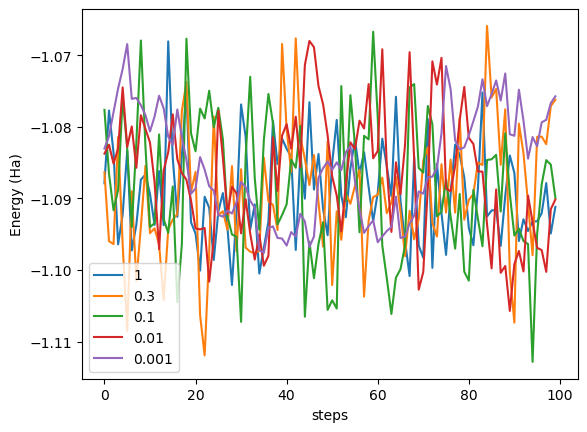

In [43]:
for i in t:
    plt.plot(ab_e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [44]:
#VMC
#

from recipes import DMC, VMC

for fname in ['vmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

#Timestep error tests
t = [1, 0.3, 0.1, 0.01, 0.001]
e_t_abvmc = []
e_t_abvmc_err = []
e_dict = {}
for dt in t:
    for fname in ['vmc.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    VMC("scf.hdf5", "vmc.hdf5", verbose=True, 
        tstep=dt, 
        nconfig=nconfig,     
        nblocks=nblocks,
        nsteps_per_block=nsteps_per_block,
       )
    with h5py.File("vmc.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_abvmc.append(e_m)
        e_t_abvmc_err.append(e_d)



----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

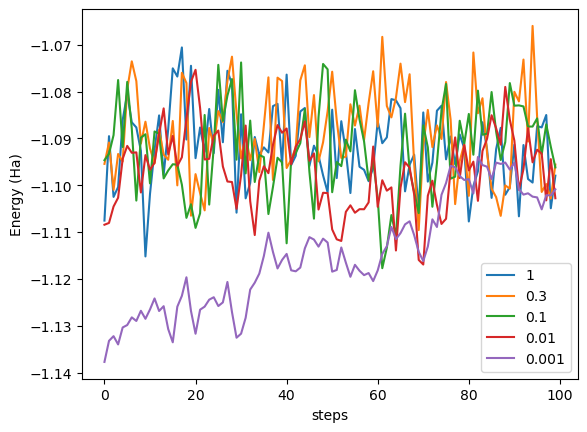

In [45]:
for i in t:
    plt.plot(e_dict[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [46]:
#pyqmc VMC
#
#
import pyqmc
print(pyqmc.__file__)

#Timestep error tests
t = [1, 0.3, 0.1, 0.01]
e_t_vmc_base = []
e_t_vmc_base_err = []
e_dict_base = {}
for dt in t:
    for fname in ['vmc-base.hdf5']:
        if os.path.isfile(fname):
            os.remove(fname)    
    dt_steps = int(nblocks*nsteps_per_block*tstep/dt)
    dt_steps = 100 if dt_steps < 1000 else dt_steps
    dt_steps = 200 if dt_steps > 2000 else dt_steps 
    dt_discard = int(dt_steps/2)
    print(dt_steps, dt_discard)
    pyqmc.recipes.VMC("scf.hdf5", "vmc-base.hdf5", verbose=True, 
                      nsteps =dt_steps, 
                      tstep=dt, 
                      nconfig=nconfig,     
                      nblocks=nblocks,
                      nsteps_per_block=nsteps_per_block)
    with h5py.File("vmc-base.hdf5") as f:
        etot_t = f['energytotal'][...] 
    e_dict_base[dt]=etot_t
    for e in [etot_t]:
        e_m = np.mean(e[dt_discard:])
        e_d = np.var(e[dt_discard:])
        e_t_vmc_base.append(e_m)
        e_t_vmc_base_err.append(e_d)



/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyqmc/__init__.py
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done
100 50
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

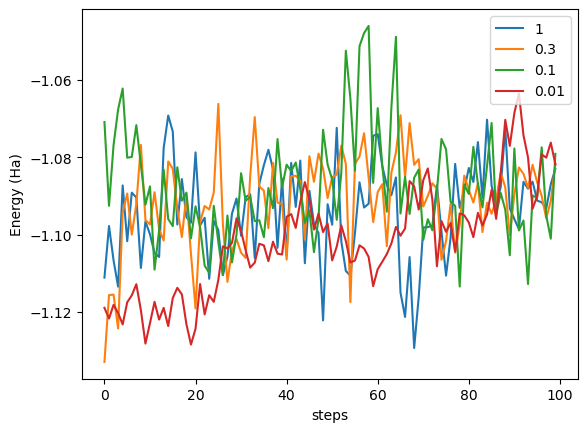

In [47]:
for i in t:
    plt.plot(e_dict_base[i], label=str(i))
plt.legend()
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')